In [34]:
#import paskages
import os
import zipfile
import random
from sklearn.model_selection import train_test_split
import pandas as pd

import shutil
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
#  Define Paths
base_dir = "dogs_vs_cats"
train_zip = "/kaggle/input/dogs-vs-cats/train.zip"
test_zip = "/kaggle/input/dogs-vs-cats/test1.zip"

In [36]:
# Create necessary directories
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test1")
train_data_dir = os.path.join(base_dir, "training_data")
val_data_dir = os.path.join(base_dir, "validation_data")

In [37]:
!ls /content


dogs-vs-cats  dogs_vs_cats  sample_data  sampleSubmission.csv  test1.zip  train.zip


In [38]:
import zipfile
import os

train_zip = '/content/train.zip'  # Update path if necessary
base_dir = '/content/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')

# Create base directory if it doesn't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Check if the zip file is valid
try:
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.testzip()  # Test the zip file integrity
        zip_ref.extractall(base_dir)
    print("Extraction successful")
except zipfile.BadZipFile:
    print(f"Error: {train_zip} is not a valid zip file.")
except Exception as e:
    print(f"Error: {e}")


Extraction successful


In [39]:
# Extract train data
if not os.path.exists(train_dir):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

In [40]:
# Split Data into Training and Validation Sets
all_images = os.listdir(train_dir)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

In [41]:
def organize_data(image_list, source_dir, target_dir):
    for img in image_list:
        category = "dog" if "dog" in img else "cat"
        target_path = os.path.join(target_dir, category)
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        shutil.copy(os.path.join(source_dir, img), os.path.join(target_path, img))

In [42]:
organize_data(train_images, train_dir, train_data_dir)
organize_data(val_images, train_dir, val_data_dir)

In [43]:
# Display sample images
def show_samples(base_folder, category, sample_count=3):
    path = os.path.join(base_folder, category)
    images = os.listdir(path)[:sample_count]
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img = plt.imread(os.path.join(path, img_name))
        plt.subplot(1, sample_count, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
    plt.show()

In [44]:
# Print folder statistics
def folder_stats(base_folder):
    for category in ['dog', 'cat']:
        path = os.path.join(base_folder, category)
        print(f"{category.capitalize()} images in {base_folder}: {len(os.listdir(path))}")

Training Data:
Dog images in dogs_vs_cats/training_data: 9964
Cat images in dogs_vs_cats/training_data: 10036


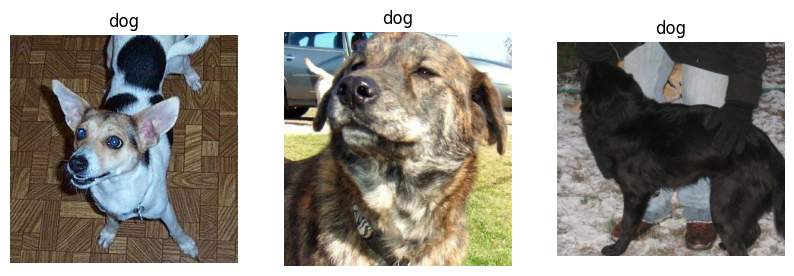

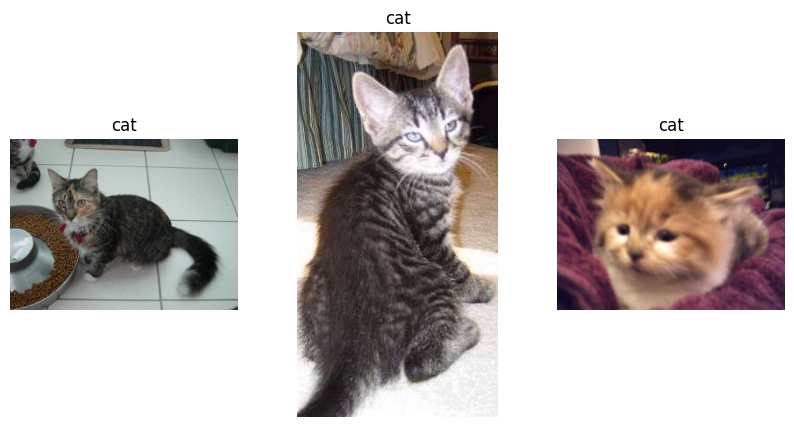

In [45]:
# Show statistics and sample images
print("Training Data:")
folder_stats(train_data_dir)
show_samples(train_data_dir, 'dog')
show_samples(train_data_dir, 'cat')

Validation Data:
Dog images in dogs_vs_cats/validation_data: 2536
Cat images in dogs_vs_cats/validation_data: 2464


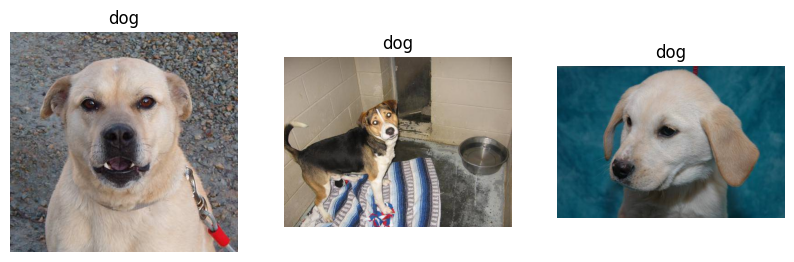

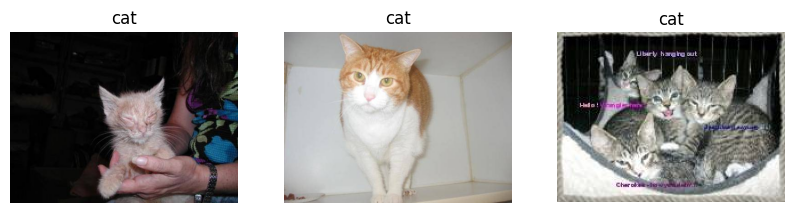

In [46]:
print("Validation Data:")
folder_stats(val_data_dir)
show_samples(val_data_dir, 'dog')
show_samples(val_data_dir, 'cat')

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [48]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [50]:
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [51]:
pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [52]:
# Freeze pre-trained layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [53]:
# Add  layers
x = layers.Flatten()(pretrained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [54]:
model = Model(pretrained_model.input, x)

In [55]:
# Compile  model
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [56]:
# add calback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("cats_dogs_model.keras", save_best_only=True)

In [57]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 191s 277ms/step - accuracy: 0.8686 - loss: 0.8512 - val_accuracy: 0.9652 - val_loss: 0.0937
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 249ms/step - accuracy: 0.9200 - loss: 0.2140 - val_accuracy: 0.9696 - val_loss: 0.0836
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 248ms/step - accuracy: 0.9279 - loss: 0.1934 - val_accuracy: 0.9654 - val_loss: 0.0865
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 249ms/step - accuracy: 0.9303 - loss: 0.1735 - val_accuracy: 0.9628 - val_loss: 0.0941
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 242ms/step - accuracy: 0.9287 - loss: 0.1785 - val_accuracy: 0.9702 - val_loss: 0.0868
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 246ms/step - accuracy: 0.9328 - loss: 0.1750 - val_accuracy: 0.9664 - val_loss: 0.0874
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 248ms/step - accuracy: 0.9331 - loss: 0.1685 - val_accuracy: 0.9678 - val_loss: 0.0956


In [58]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

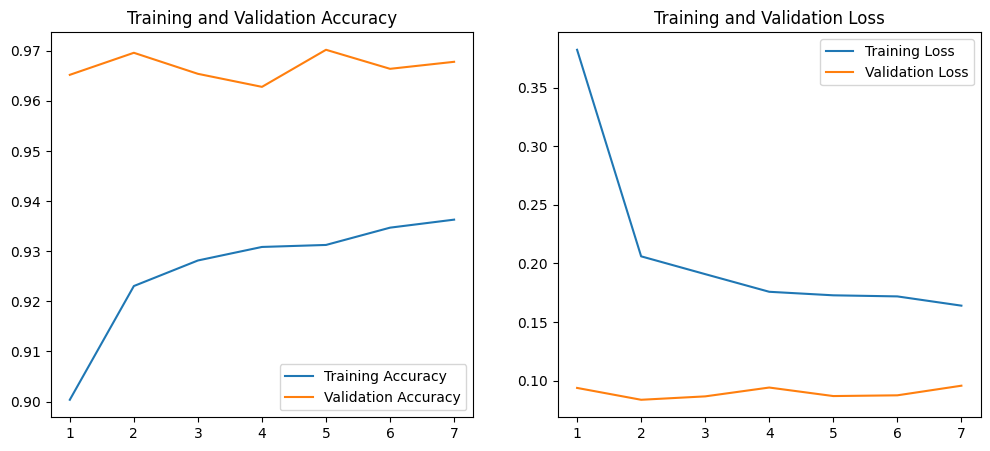

In [59]:
plot_training_results(history)

In [71]:
import os

test_dir = 'dogs_vs_cats/test1'  # Your original relative path
test_dir = os.path.abspath(test_dir)  # Convert to absolute path

# ... rest of your code ...

In [73]:
import os
import zipfile
import pandas as pd

# Step 1: Define directory paths
base_dir = '/content/dogs_vs_cats'  # Base directory for the extracted files
train_zip = '/content/train.zip'  # Path to the ZIP file (update if necessary)
test_dir = os.path.join(base_dir, 'test')  # Path to the test directory

# Step 2: Check if the ZIP file exists and extract it if necessary
if os.path.exists(train_zip):
    try:
        # Extract the ZIP file if it's not already extracted
        with zipfile.ZipFile(train_zip, 'r') as zip_ref:
            zip_ref.extractall(base_dir)
        print(f"Files successfully extracted to: {base_dir}")
    except zipfile.BadZipFile:
        print(f"Error: {train_zip} is not a valid ZIP file.")
else:
    print(f"Error: {train_zip} not found. Please upload the dataset.")

# Step 3: Check if the test directory exists after extraction
if os.path.exists(test_dir):
    print("Test directory found. Listing image files...")

    # Step 4: Get all image file paths in the test directory
    image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')]

    # Step 5: Create a DataFrame with the image file paths
    df = pd.DataFrame({'filename': image_paths})

    # Display the first few rows of the DataFrame
    print(df.head())

else:
    print(f"Error: Test directory not found at {test_dir}. Please check if the dataset was extracted correctly.")


Files successfully extracted to: /content/dogs_vs_cats
Error: Test directory not found at /content/dogs_vs_cats/test. Please check if the dataset was extracted correctly.
